In [1]:
import pandas as pd
import numpy as np
from utils.conn_data import load_pickle
import os
from os.path import join
import glob
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("ggplot")

In [2]:
outputs_path = os.path.join(os.path.dirname(os.getcwd()), "src", "data", "outputs")

# fs_methods = ["lasso", "multivariate-granger", "pairwise-granger", "var-lingam", "dynotears"]
fs_methods = ["lasso"]

In [3]:
outputs_path

'/Users/danieloliveira/Documents/Daniel/codes/cml-fin/src/data/outputs'

In [4]:
class backtester:
    def __init__(self, dfPred):
        self.yPred = dfPred["prediction"]
        self.yTrue = dfPred["true"]
        
    def simpleStrategy(self):
        self.stratName = "simple"
        self.pnl = np.sign(self.yPred) * self.yTrue
        #self.pnl = self.pnl.reshape(-1)
        return self.pnl


def calculateSharpeRatio(dfPnl, annulaize = 12, rf = 0):
    sr = (dfPnl.mean() - rf) / dfPnl.std() * np.sqrt(annulaize)
    return sr

def calculateAnnualizedReturn(dfPnl, annulaize = 12):
    cr = dfPnl.mean() * annulaize * 100
    return cr

In [5]:
etf = "SPY"
for i, fs in enumerate(fs_methods):
    results_files = glob.glob(os.path.join(outputs_path, fs, "etfs_macro_large", f"{etf}*.pickle"))
    dfPred = load_pickle(results_files[0])["predictions"]
    dfPred = np.log(1 + dfPred / 100)
    
    bt = backtester(dfPred)
    bt.simpleStrategy()
    
    if i == 0:
        dfPnl = dfPred[["true"]].copy()
        dfPnl.columns = [etf]
    dfPnl[fs] = bt.pnl

    

In [6]:
dfPred.tail()

,prediction_zscore,true_zscore,prediction,true
date,,,,
2022-07-31,-0.000535,0.018667,0.000027,0.000881
2022-08-31,-0.001899,-0.010667,-0.000031,-0.000417
2022-09-30,0.008632,-0.023248,0.000436,-0.000967
2022-10-31,0.001733,0.016297,0.000125,0.000781
2022-11-30,-0.005346,0.010892,-0.000188,0.000541


In [7]:
calculateSharpeRatio(dfPnl)

SPY      0.586480
lasso    0.995677
dtype: float64

In [8]:
calculateAnnualizedReturn(dfPnl)

SPY      0.087717
lasso    0.141306
dtype: float64

Text(0, 0.5, 'Cumulative returns (%)')

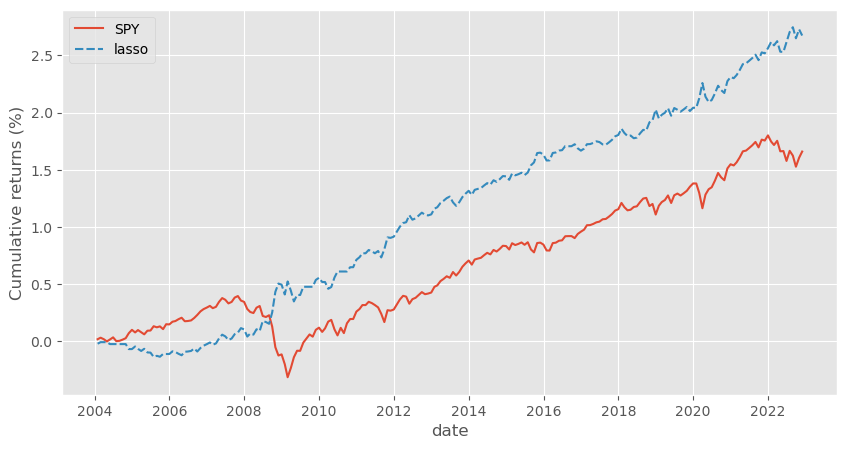

In [9]:
fig, ax = plt.subplots(1, 1, figsize = (10, 5))
sns.lineplot(data = dfPnl.cumsum() * 100, ax = ax)
ax.set_ylabel("Cumulative returns (%)")

In [15]:
fig.savefig("PnLPlot.png", bbox_inches = "tight")